<a href="https://colab.research.google.com/github/kofujimura/foods-similarity-using-LLM/blob/main/LLM%E3%82%92%E6%B4%BB%E7%94%A8%E3%81%97%E3%81%9F%E9%A3%9F%E5%93%81%E9%96%93%E3%81%AE%E9%A1%9E%E4%BC%BC%E5%BA%A6%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMを活用した食品間の類似度の可視化
生成AIのembedingモデルを活用して114種類の食品間の類似度を算出します。Google Colaboratoryでの実行を前提として、OPENAI_API_KEYの値をColaboratoryのuserdataに設定することが必要です。

## ライブラリのインストールとAPIキー設定

### Subtask:
必要なPythonライブラリ（openai, pandas, numpy, openpyxl）をインストールし、OpenAI APIキーを設定します。


In [1]:
# ===============================
# 1. 必要ライブラリのインストール
# ===============================
!pip install -q openai pandas numpy openpyxl

from openai import OpenAI
import pandas as pd
import numpy as np
from numpy.linalg import norm

# ===============================
# 2. APIキー設定（重要）
# ===============================
# 左側の「鍵マーク」から環境変数 OPENAI_API_KEY を追加する
# ここに直接書いてもOK（ただし公開しないこと）
from google.colab import userdata
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

## データファイルの読み込み

### Subtask:
提供されたパスから[`foods-text.xlsx`](https://docs.google.com/spreadsheets/d/18IVgqL7n7gk1TIRpAi8vcOJDdvYKeDez/edit?usp=sharing&ouid=109677197366385298416&rtpof=true&sd=true)ファイルをPandas DataFrameとして読み込みます。


In [2]:
file_path = "/content/foods-text.xlsx"
df = pd.read_excel(file_path)
df.head()

,食品名,実際の調理法,主な材料
0,鶏のから揚げ,一口大に切った鶏もも肉にショウガ汁、すりおろしニンニク、醤油、酒などで下味をつけて揉み、片栗...,鶏肉（もも肉またはむね肉）、醤油、みりん、酒、にんにく、生姜、塩、胡椒、片栗粉または小麦粉、揚げ油
1,アイスクリーム,牛乳や生クリーム、砂糖、卵黄などを混ぜ合わせ、攪拌しながら凍らせて作る冷菓。,牛乳、生クリーム、砂糖、卵黄、バニラエッセンス（バニラビーンズ）など
2,フライドポテト,じゃがいもを食べやすい大きさに切って油で揚げる。揚げたてに塩を振って食べるのが一般的。,じゃがいも、サラダ油、塩
3,オムライス,ケチャップで味付けしたチキンライスを薄焼き卵で包んで作る洋食。,鶏肉、玉ねぎ、ご飯、卵、トマトケチャップ、バター、塩、胡椒
4,豚汁,豚肉と根菜類を具に味噌で仕立てた汁物。豚肉、大根、人参、ごぼう、こんにゃく等を炒めてから出汁...,豚肉、大根、人参、ごぼう、こんにゃく、里芋、長ネギ、味噌、出汁


## Embedding用テキストの整形

### Subtask:
DataFrameの各行から「食品名」「調理法」「主な材料」を結合し、Embedding生成用のテキストリストを作成します。


In [3]:
# ===============================
# 4. Embedding 用のテキスト整形
# ===============================
def build_text(row):
    return (
        f"食品名：{row['食品名']}。"
        f"調理法：{row['実際の調理法']}。"
        f"主な材料：{row['主な材料']}。"
    )

texts = df.apply(build_text, axis=1).tolist()

## Embeddingの生成

### Subtask:
整形したテキストリストを使用してOpenAIの`text-embedding-3-small`モデルでEmbeddingを生成します。この処理には時間がかかる場合があります。


In [4]:
print("Embedding を生成中...（1〜2分かかる場合あり）")

response = client.embeddings.create(
    model="text-embedding-3-small",
    input=texts
)

embeddings = np.array([item.embedding for item in response.data])
embeddings.shape

Embedding を生成中...（1〜2分かかる場合あり）


(114, 1536)

## コサイン類似度関数の定義

### Subtask:
2つのベクトル間のコサイン類似度を計算する`cosine_sim`関数を定義します。


In [5]:
# ===============================
# 6. コサイン類似度の計算関数
# ===============================
def cosine_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b)))

## 類似料理の検索と表示

### Subtask:
指定されたインデックスの料理に類似する料理を、生成したEmbeddingとコサイン類似度関数を用いて検索し、上位5件を表示します。


In [6]:
# ===============================
# 7. 任意の料理に似た料理を上位5件出す
# ===============================
def similar_food(index, top_k=5):
    target_vec = embeddings[index]
    sims = []

    for i, vec in enumerate(embeddings):
        if i == index:
            continue
        sim = cosine_sim(target_vec, vec)
        sims.append((i, sim))

    sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)

    print(f"=== 「{df.iloc[index]['食品名']}」に似ている料理 TOP {top_k} ===")
    for idx, sim in sims_sorted[:top_k]:
        print(f"類似度: {sim:.3f} | {df.iloc[idx]['食品名']}")

# 例：0番目の料理に似た料理
similar_food(0)

=== 「鶏のから揚げ」に似ている料理 TOP 5 ===
類似度: 0.642 | フライドチキン
類似度: 0.577 | しょうが焼き
類似度: 0.575 | フライドポテト
類似度: 0.571 | 肉じゃが
類似度: 0.571 | ハンバーグ


## D3.js用データの準備: ノードの生成

### Subtask:
`df` DataFrameからD3.jsグラフのノードリストを作成します。各ノードには、食品のID（インデックス）と、`df`の「食品名」カラムからの食品名を含めます。ノードに色をつけるために、k-mean法で各食品ベクトルをクラスタリングします。第４回の授業と同様にkの値を15にしてみましょう。

## Modify nodes generation

### Subtask:
既存のノード生成コードを修正し、抽出したグループマッピングを使用して各ノードに適切な`group`属性を設定します。


In [7]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=15)

# K-meansクラスタリングの実行し、結果をdfに追加
df["kmeans"]=k_means.fit_predict(embeddings)

# クラスタリング結果でソートして表示
df.sort_values(by="kmeans")[["kmeans"]]


,kmeans
98,0
101,0
12,1
11,1
20,1
...,...
51,14
21,14
50,14
84,14


In [9]:
nodes = []
for i, food_name in enumerate(df['食品名']):
    group_id = df['kmeans'][i]
    nodes.append({
        'id': food_name,
        'group': group_id
    })

print(f"Generated {len(nodes)} nodes for the D3.js graph with group information.")

Generated 114 nodes for the D3.js graph with group information.


## 全食品ペア間の類似度計算

### Subtask:
すべての食品ペアについて、コサイン類似度を計算し、データ構造に格納します。


In [10]:
similarity_scores = []
n_foods = len(embeddings)

for i in range(n_foods):
    for j in range(i + 1, n_foods):
        sim = cosine_sim(embeddings[i], embeddings[j])
        similarity_scores.append((i, j, sim))

print(f"Calculated {len(similarity_scores)} similarity scores for all unique food pairs.")

Calculated 6441 similarity scores for all unique food pairs.


## D3.js用データの準備: エッジの抽出

### Subtask:
各食品について、上位10件の類似する食品をエッジとして抽出し、後続のD3.jsノード・エッジデータ生成に備えます。

### Subtask:
各食品のエッジ数を計算し、その分布をヒストグラムで可視化します。

## エッジ抽出ロジックの修正 (Top Kの削減)

### Subtask:
各食品について、類似する食品を上位10件から上位5件に減らすようにエッジ抽出ロジックを修正します。


In [11]:
import collections

edges_raw = collections.defaultdict(list)

for i, j, sim in similarity_scores:
    edges_raw[i].append({'target_id': j, 'value': sim})
    edges_raw[j].append({'target_id': i, 'value': sim})

edges = []
for source_id, connections in edges_raw.items():
    # Sort connections by similarity value in descending order and take the top 5
    top_connections = sorted(connections, key=lambda x: x['value'], reverse=True)[:5]
    for conn in top_connections:
        # Add edge if it's not already added (to avoid duplicates from both directions)
        # Ensure each edge is unique and stored only once (e.g., lower index as source)
        if source_id < conn['target_id']:
            edges.append({
                'source': df.iloc[source_id]['食品名'],
                'target': df.iloc[conn['target_id']]['食品名'],
                'value': conn['value'] * 10  # 類似度を10倍にスケール
            })

print(f"Generated {len(edges)} unique edges for the D3.js graph.")

Generated 289 unique edges for the D3.js graph.


## D3.js用データの最終出力

### Subtask:
生成されたノードリストとエッジリストを結合し、D3.jsが消費できる単一のJSONオブジェクト（`{"nodes": [...], "links": [...]}`の形式）として出力します。

In [13]:
import json

# Ensure 'group' values in nodes are standard Python ints
cleaned_nodes = []
for node in nodes:
    cleaned_node = node.copy()
    cleaned_node['group'] = int(cleaned_node['group'])
    cleaned_nodes.append(cleaned_node)

d3_data = {
    "nodes": cleaned_nodes,
    "links": edges
}

# JSON形式で出力
json_output = json.dumps(d3_data, indent=2, ensure_ascii=False)

print("D3.js compatible JSON data regenerated with scaled link values.")
print(json_output)

D3.js compatible JSON data regenerated with scaled link values.
{
  "nodes": [
    {
      "id": "鶏のから揚げ",
      "group": 8
    },
    {
      "id": "アイスクリーム",
      "group": 6
    },
    {
      "id": "フライドポテト",
      "group": 8
    },
    {
      "id": "オムライス",
      "group": 8
    },
    {
      "id": "豚汁",
      "group": 11
    },
    {
      "id": "餃子",
      "group": 13
    },
    {
      "id": "ご飯",
      "group": 3
    },
    {
      "id": "ハンバーグ",
      "group": 2
    },
    {
      "id": "ローストビーフ",
      "group": 7
    },
    {
      "id": "にぎり寿司",
      "group": 3
    },
    {
      "id": "味噌汁",
      "group": 11
    },
    {
      "id": "ビーフシチュー",
      "group": 1
    },
    {
      "id": "サーロインステーキ",
      "group": 1
    },
    {
      "id": "ハンバーガ",
      "group": 2
    },
    {
      "id": "ネギトロ丼",
      "group": 10
    },
    {
      "id": "プリン",
      "group": 6
    },
    {
      "id": "海老の天ぷら",
      "group": 3
    },
    {
      "id": "肉じゃが",
      "group": 1
    },

こうして作られたJSONファイルはD3.jsの[こちらのCodeSandbox](https://n34r28.csb.app/)を使ってグラフ可視化することが可能です。

以下は各ノードの次数（エッジ数）の分布のヒストグラムです。必要に応じて抽出するエッジ数（現在は５）を調整してください。

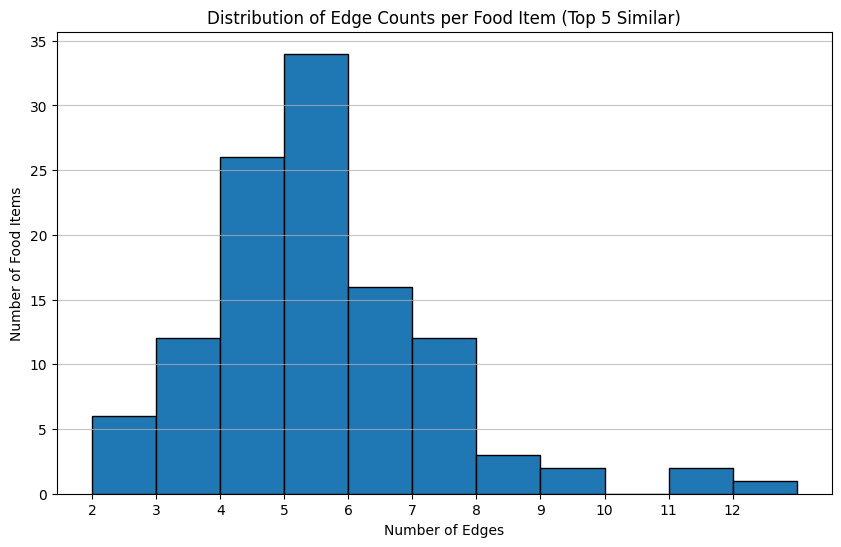

In [14]:
import matplotlib.pyplot as plt

# 各ノードのエッジ数をカウント
degrees = collections.defaultdict(int)
for edge in edges:
    degrees[edge['source']] += 1
    degrees[edge['target']] += 1

# エッジ数のリストを抽出
edges_per_node = list(degrees.values())

# ヒストグラムを作成
plt.figure(figsize=(10, 6))
plt.hist(edges_per_node, bins=range(min(edges_per_node), max(edges_per_node) + 2), edgecolor='black')
plt.title('Distribution of Edge Counts per Food Item (Top 5 Similar)')
plt.xlabel('Number of Edges')
plt.ylabel('Number of Food Items')
plt.xticks(range(min(edges_per_node), max(edges_per_node) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()